In [2]:
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns

# load data

In [10]:
df = pd.read_csv(r"/kaggle/input/next-word-prediction/twitter_training.csv", header = None)

df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       74682 non-null  int64 
 1   1       74682 non-null  object
 2   2       74682 non-null  object
 3   3       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [12]:
df[2].value_counts()

2
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [13]:
tweets = df.iloc[:, 3:4]
tweets

,3
0,im getting on borderlands and i will murder yo...
1,I am coming to the borders and I will kill you...
2,im getting on borderlands and i will kill you ...
3,im coming on borderlands and i will murder you...
4,im getting on borderlands 2 and i will murder ...
...,...
74677,Just realized that the Windows partition of my...
74678,Just realized that my Mac window partition is ...
74679,Just realized the windows partition of my Mac ...
74680,Just realized between the windows partition of...


In [14]:
tweets.columns = ["Tweets"]

In [15]:
tweets

,Tweets
0,im getting on borderlands and i will murder yo...
1,I am coming to the borders and I will kill you...
2,im getting on borderlands and i will kill you ...
3,im coming on borderlands and i will murder you...
4,im getting on borderlands 2 and i will murder ...
...,...
74677,Just realized that the Windows partition of my...
74678,Just realized that my Mac window partition is ...
74679,Just realized the windows partition of my Mac ...
74680,Just realized between the windows partition of...


# text preprocessing

In [16]:
re_special_char = "[^a-z\s]"
def text_preprocessing(review):
    # convert in to string to overcome from float values
    review = str(review)
    #Normalizing the case 
    review = review.lower()
    #Removal of special characters
    review = re.sub(re_special_char,"", review)
#     # word tokenization
#     review = review.split()
#     #removing stop words and making stemming
#     review = [ps.stem(each_word) for each_word in review if each_word not in sw]
#     review = " ".join(review)
    return review

In [17]:
tweets["Tweets"] = tweets["Tweets"].apply(text_preprocessing)

In [18]:
tweets

,Tweets
0,im getting on borderlands and i will murder yo...
1,i am coming to the borders and i will kill you...
2,im getting on borderlands and i will kill you all
3,im coming on borderlands and i will murder you...
4,im getting on borderlands and i will murder y...
...,...
74677,just realized that the windows partition of my...
74678,just realized that my mac window partition is ...
74679,just realized the windows partition of my mac ...
74680,just realized between the windows partition of...


### Tokenization

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [20]:
tk = Tokenizer()
tk.fit_on_texts(tweets["Tweets"])

In [21]:
len(tk.word_index) 

38492

In [22]:
tk.word_index["fantastic"]

682

In [23]:
tk.index_word[551]

'kinda'

In [24]:
tweets["Tweets"][600]

'well this is certainly a development'

In [25]:
token_list = tk.texts_to_sequences(["well this is certainly a development"])

token_list  # it is in two dimensions

[[160, 10, 7, 1296, 5, 1960]]

In [26]:
# doing slice and now we have one dimension
token_list = token_list[0]
token_list

[160, 10, 7, 1296, 5, 1960]

In [27]:
"well this is certainly a development"

'well this is certainly a development'

In [28]:
input_sequences = []

for i in range(1, len(token_list)-1):
    n_gram_seq = token_list[0:i+2]  # words are iterating # and min two words taking as input 
    input_sequences.append(n_gram_seq)

In [29]:
# note: in all list "-1" index position is considered as next word prediction based on previous words
input_sequences   

[[160, 10, 7],
 [160, 10, 7, 1296],
 [160, 10, 7, 1296, 5],
 [160, 10, 7, 1296, 5, 1960]]

In [30]:
def gen_sequences(data):
    input_seq = []
    for each_tweet in data:
        token_list = tk.texts_to_sequences([each_tweet])
        # converting 2d to 1d by taking slice
        token_list = token_list[0]
        for i in range(1,len(token_list)-1):
            n_gram_seq = token_list[0:i+2]   # taking min 3 words as input for next word prediction
            input_seq.append(n_gram_seq)
    return input_seq

In [31]:
input_sequences = gen_sequences(tweets["Tweets"])

In [32]:
input_sequences[0:10]

[[30, 157, 13],
 [30, 157, 13, 123],
 [30, 157, 13, 123, 4],
 [30, 157, 13, 123, 4, 2],
 [30, 157, 13, 123, 4, 2, 49],
 [30, 157, 13, 123, 4, 2, 49, 1656],
 [30, 157, 13, 123, 4, 2, 49, 1656, 12],
 [30, 157, 13, 123, 4, 2, 49, 1656, 12, 26],
 [2, 100, 378],
 [2, 100, 378, 3]]

In [33]:
max_seq_len = max([len(seq) for seq in input_sequences])
max_seq_len

166

In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [35]:
# pre-padding is mandatory for next word prediction
input_sequences = pad_sequences(input_sequences, maxlen = max_seq_len, padding='pre')

input_sequences

array([[   0,    0,    0, ...,   30,  157,   13],
       [   0,    0,    0, ...,  157,   13,  123],
       [   0,    0,    0, ...,   13,  123,    4],
       ...,
       [   0,    0,    0, ...,  494,   60,    2],
       [   0,    0,    0, ...,   60,    2,  284],
       [   0,    0,    0, ...,    2,  284, 2008]], dtype=int32)

In [36]:
input_sequences.shape

(1185657, 166)

In [37]:
# sliced_seq = input_sequences[0:100000,:]

# sliced_seqA

In [38]:
# sliced_seq.shape

In [39]:
# Input data 

X = input_sequences[:,:-1]
X.shape

(1185657, 165)

In [40]:
X

array([[  0,   0,   0, ...,   0,  30, 157],
       [  0,   0,   0, ...,  30, 157,  13],
       [  0,   0,   0, ..., 157,  13, 123],
       ...,
       [  0,   0,   0, ...,  48, 494,  60],
       [  0,   0,   0, ..., 494,  60,   2],
       [  0,   0,   0, ...,  60,   2, 284]], dtype=int32)

In [41]:
# target data 

y = input_sequences[:,-1]

In [42]:
tk.index_word[5]

'a'

In [43]:
y.shape

(1185657,)

In [44]:
y

array([  13,  123,    4, ...,    2,  284, 2008], dtype=int32)

In [45]:
total_word = len(tk.word_index) 

In [46]:
total_word

38492

# loading word embedding of Glove pretrained model

In [47]:
import tqdm

In [48]:
embedding_vector = {}

In [49]:
data = open("/kaggle/input/glovefile/glove.6B.300d.txt", mode = "r", encoding = "utf8")

for each_line in tqdm.tqdm(data):
    value = each_line.split()
    word = value[0]
    emb_vec = np.array(value[1:], dtype = "float32")
    # creating key and value dictionary
    embedding_vector[word] = emb_vec

400000it [00:33, 12074.92it/s]


In [50]:
#embedding_vector

In [51]:
total_words = len(tk.word_index)
total_words

38492

In [52]:
embedding_matrix = np.zeros((total_words + 1, 300))  # data is in 300 dimension 
                                                    # for unknown word we need to add +1

embedding_matrix.shape  # total words are 38492

(38493, 300)

In [53]:
# each row indicates one word
# right whole words are represented by zero but we dont need as zeros becz we have 
# pretrained model weights of GLovE with 300 dimensions
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [54]:
# in pretrained model nearly 4lak words are existed but we dont need those all words, 
# we just focus on our len of words according to our data

len(embedding_vector) 

400000

In [55]:
# now filling embedding_matrix with embedding_vector of position 

for word, position in tk.word_index.items():
    value = embedding_vector.get(word)
    if value is not None:
        embedding_matrix[position] = value
    else: 
        embedding_matrix[position] = np.random.rand(300)

In [56]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04656   ,  0.21318001, -0.0074364 , ...,  0.0090611 ,
        -0.20988999,  0.053913  ],
       [-0.13292   ,  0.16985001, -0.1436    , ..., -0.23778   ,
         0.14766   ,  0.62901998],
       ...,
       [ 0.47334318,  0.67789834,  0.35205292, ...,  0.71155043,
         0.50911462,  0.26290192],
       [-0.17676   ,  0.0069262 , -0.50933999, ..., -0.19812   ,
         0.3608    ,  0.14391001],
       [ 0.5951973 ,  0.09315642,  0.95400667, ...,  0.0323078 ,
         0.20146306,  0.30274259]])

In [57]:
embedding_matrix.shape

(38493, 300)

# Build the Architecture

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dropout, Dense

In [59]:
# Initializing the model
model = Sequential()

## Add Embedding layer

In [60]:
X.shape[1]

165

In [61]:
# capture 100 features(100 neurons) for each words in a document (165,100)
# return 100 features
# no.of.features is a hyperparameter in embedding layer
# for each word having 100 neuorns(features) becz of embedding layer 
# embedding layer is just like feature extraction layer
# in embedding layer, the values will be updated during training time and also it helps to find next word.
# total_word + 1 --> +1 becz for extra dimension which is out of vocab (OOV) words
# embedding weights are initialized  

emb_layer = Embedding(total_word + 1, 300, weights = [embedding_matrix],input_length = X.shape[1])

# in embedding we have one parameter (trainable = False / True)
# False --> embedding weights are freezed, it means randomly initializing weights 
# True -->  embedding weights are initialized and started training

In [62]:
model.add(emb_layer)

### Add the LSTM-1 Layer

In [63]:
#return_sequences -- True when we want to add another LSTM Layer after this
#return_sequences -- False -- When we are adding a Dense layer after LSTM

lstm_layer_1 = LSTM(kernel_initializer = "random_uniform", 
                    return_sequences = True ,units = 50 )

In [64]:
model.add(lstm_layer_1)

In [74]:
model.add(Dropout(0.05))

### Add the LSTM-2 Layer

In [65]:
# return_seq = False --> returns dense output last LSTM LAYER 

lstm_layer_2 = LSTM(kernel_initializer = "random_uniform", 
                    return_sequences = False ,units = 80 )  

In [ ]:
model.add(Dropout(0.05))

In [66]:
model.add(lstm_layer_2)

### Add the output layer

In [67]:
ouput_layer = Dense(kernel_initializer = "random_uniform", activation = "softmax", units = total_word)

In [68]:
model.add(ouput_layer)

In [69]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 165, 300)          11547900  
                                                                 
 lstm (LSTM)                 (None, 165, 50)           70200     
                                                                 
 lstm_1 (LSTM)               (None, 80)                41920     
                                                                 
 dense (Dense)               (None, 38492)             3117852   
                                                                 
Total params: 14777872 (56.37 MB)
Trainable params: 14777872 (56.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
from tensorflow.keras.utils import plot_model

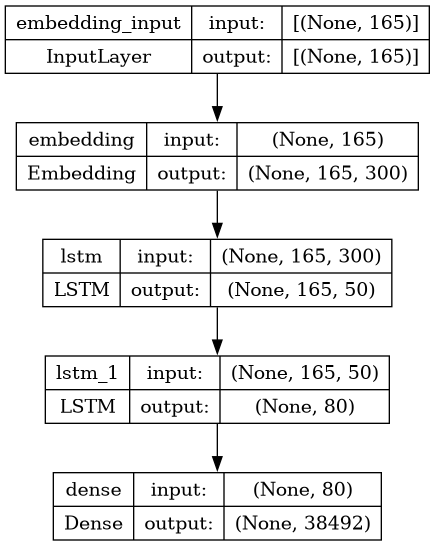

In [71]:
plot_model(model,show_shapes = True)

In [72]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

## note: please increase epochs 

In [73]:
hist = model.fit(X,y, epochs = 1, batch_size = 32)
hist

37052/37052 [==============================] - 1086s 29ms/step - loss: nan - accuracy: 0.0219


# save model

In [65]:
from pickle import dump,load
# pickle
import pickle
from keras.models import load_model

In [60]:
model.save('model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


In [66]:
pickle.dump(tk, open('tokenizer.pkl', 'wb'))

In [67]:
model = load_model("embedd_model.h5")

tokenizer = pickle.load(open("embedd_tokenizer.pkl", 'rb'))

# prediction

In [ ]:
def predict_next_words(model, tk, text) :
    
    sequence = tokenizer.texts_to_sequences([text])
    pad_encoded = pad_sequences(sequence, maxlen=max_seq_len-1, truncating='pre')
    sequence = np.array(pad_encoded)
    
    preds = np.argmax(model.predict(sequence))
    predicted_word = ""
    #print(preds)
    
    for key, value in tk.word_index.items() :
        if value == preds :
            predicted_word = key
            break
    
    return predicted_word

In [86]:
l1 = ["this was the first Borderlands session in a long time where i actually had a really satisfying fighting experience. i got some really good kills"]

l2 = ["imma is probably playing a bit of borderland tps. That will be fun."]

l3 = ["Come meet one of the beautiful gods of gambling."]

In [95]:
l = ["this was the first Borderlands", "imma is probably playing a bit of", "Come meet one of the beautiful gods of", "0"]

for i in l :
    
    text = i
    
    if text == "0" :
        print()
        print("Execution completed...")
        break
    
    else :
        try :
            text = text.split(" ")
            a = len(text)
            text = text[-a:]
            print("Input :", i)
            print("Output : ", i, predict_next_words(model, tk, text))
            print()
            
        except Exception as e :
            print("Error occured : ", e)
            continue

Input : this was the first Borderlands

1/1 [==============================] - 0s 22ms/step

Output :  this was the first Borderlands session



Input : imma is probably playing a bit of

1/1 [==============================] - 0s 22ms/step

Output :  imma is probably playing a bit of borderland



Input : Come meet one of the beautiful gods of

1/1 [==============================] - 0s 22ms/step

Output :  Come meet one of the beautiful gods of gambling





Execution completed...


# prediction by another method

In [1]:
max_seq_len = 165

In [ ]:
re_special_char = "[^a-z\s]"
def text_preprocessing(review):
    # convert in to string to overcome from float values
    review = str(review)
    #Normalizing the case 
    review = review.lower()
    #Removal of special characters
    review = re.sub(re_special_char,"", review)
    return review

In [ ]:
def pred_next_word(text, max_seq_len, tokenizer):
    text = text_preprocessing(text)
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen = max_seq_len, padding = "pre")
    y_pred = model.predict(text, verbose = 0)
    best_word_pred = np.argmax(y_pred)
    return tokenizer.index_word[best_word_pred]

##### predicting further 15 words

In [ ]:
l1 = ["this was the first Borderlands session in a long time where i actually had a really satisfying fighting experience. i got some really good kills"]
print("original_text :", l1)
print("######################")
word = "this was the first Borderlands session in a long"
for i in range(15):
    word = word + " " + pred_next_word(word,max_seq_len, tokenizer)
print(word)